# Cyclistic Bike Sharing Analysis
### Case Study

## Introduction
Cyclistic is a bike sharing company launched in 2016 based in Chicago. The company offers flexible pricing to cater to both casual riders and Cyclistic members who pay an annual fee.  Cyclistic members are believed to be more profitable and the director of marketing believes the company’s future success depends on maximising the number of annual memberships. The analytics marketing team therefore wants to understand how casual riders and members use the bikes differently and use these insights to develop a marketing strategy 
that will help convert casual riders into members.

## Business Task
This report aims to design a marketing strategy that targets casual riders and converts them into Cyclistic members.
To do this the following three questions will be addressed:

1.How do annual members and casual riders use Cyclistic bikes differently?

2.Why would casual riders buy Cyclistic annual memberships?

3.How can Cyclistic use digital media to influence casual rider to become members?

## Data Source
Public historical trip data is available from Motivate International Incorporated here and available under this licence. This data is stored in a separate csv file for each month. Data for the following criteria were included in the files: ride id, rideable type, date and time started at, date and time ride ended at, starting station name and ID, end station name and ID, starting latitude, starting longitude coordinates, end latitude and longitude coordinates and whether the user was a member or a casual rider. This data is reliable as it is public data provided by Cyclistic and the city of Chicago and includes data for all rides and is the original data source. It is also comprehensive as it provides the data required to answer the selected questions and is current and has data available up to December 2022. There are however some issues with missing entries for the station names and ID’s, as well as some longitude and latitude values.





# Data Cleaning and Manipulation
The data was stored in 12 csv files, ranging in size from 18mb to 148mb. Due to the large size of the dataset, Python was used to initially clean and manipulate the data. 
The following are processes that were carried out:



Concatenate all 12 files into a single csv file

In [1]:
# import modules
import os
import pandas as pd

# file path of raw data
file_path = "C:\\Users\\richa\\Documents\\Data Science\\Google Certificate Case Study\\2022 Data\\Raw Data\\"

# list all the files from the directory
file_list = os.listdir(file_path)

# concat all csv files together
df_raw = pd.concat([(pd.read_csv(file_path + f)) for f in file_list], ignore_index=True)

Check field names

In [2]:
df_raw.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

Check for duplicate entries

In [3]:
# check for duplicate rows and id's
print("number of duplicate rows: ", df_raw.duplicated().sum())
print("number of duplicate ride id's: ", df_raw['ride_id'].duplicated().sum())

number of duplicate rows:  0
number of duplicate ride id's:  0


Check for consistent date format

In [4]:
df_raw['started_at'] = pd.to_datetime(df_raw['started_at'], format='%Y-%m-%d %H:%M:%S', errors='raise')
df_raw['ended_at'] = pd.to_datetime(df_raw['ended_at'], format='%Y-%m-%d %H:%M:%S', errors='raise')

Add columns containing the start journey month, day of the week, hour and trip duration in minutes

In [5]:
# add month column
df_raw['month'] = df_raw['started_at'].dt.month_name()
# add day of the week column
df_raw['day_of_the_week'] = df_raw['started_at'].dt.day_name()
# add hour column
df_raw['hour'] = df_raw['started_at'].dt.hour
# add trip duration
df_raw['trip_duration_minutes'] = ((df_raw['ended_at'] - df_raw['started_at']).astype('timedelta64[s]') / 60).round(2)

Check for trip durations of zero or less and remove the rows containing them.

In [6]:
print("number of rides with a trip duration of 0 minutes or less: ",df_raw[df_raw['trip_duration_minutes'] <= 0]['ride_id'].count())
df_raw = df_raw[df_raw['trip_duration_minutes'] > 0]

number of rides with a trip duration of 0 minutes or less:  531


Add a column containing the overall journey

In [7]:
# add journey column
df_raw['journey'] = df_raw['start_station_name'] + ", " + df_raw['end_station_name']

Add columns containing the start and end co-ordinates

In [8]:
# add start coordinates column
df_raw['start_coordinates'] = df_raw['start_lat'].apply(str) + ", " + df_raw['start_lng'].apply(str)
# add end coordinates column
df_raw['end_coordinates'] = df_raw['end_lat'].apply(str) + ", " + df_raw['end_lng'].apply(str)

Count the number of entries in each column

In [9]:
df_raw.count()

ride_id                  5667186
rideable_type            5667186
started_at               5667186
ended_at                 5667186
start_station_name       4834148
start_station_id         4834148
end_station_name         4774650
end_station_id           4774650
start_lat                5667186
start_lng                5667186
end_lat                  5661328
end_lng                  5661328
member_casual            5667186
month                    5667186
day_of_the_week          5667186
hour                     5667186
trip_duration_minutes    5667186
journey                  4369052
start_coordinates        5667186
end_coordinates          5667186
dtype: int64

Count the number of entries missing in each column

In [10]:
df_raw.isna().sum()

ride_id                        0
rideable_type                  0
started_at                     0
ended_at                       0
start_station_name        833038
start_station_id          833038
end_station_name          892536
end_station_id            892536
start_lat                      0
start_lng                      0
end_lat                     5858
end_lng                     5858
member_casual                  0
month                          0
day_of_the_week                0
hour                           0
trip_duration_minutes          0
journey                  1298134
start_coordinates              0
end_coordinates                0
dtype: int64

In [11]:
print("number of rows with missing values: ", df_raw['ride_id'].count() - df_raw.dropna()['ride_id'].count())

number of rows with missing values:  1298134


#### Further analysis of missing values

How many of the rows with a missing start station name have the same starting coordinates

In [12]:
df_raw[df_raw['start_station_name'].isna()]['start_coordinates'].value_counts().sort_values(ascending=False).head(10)

41.79, -87.6     30481
41.89, -87.63    19225
41.91, -87.63    16413
41.9, -87.63     15315
41.94, -87.65    15123
41.88, -87.63    14995
41.8, -87.59     14360
41.93, -87.64    13664
41.93, -87.65    13350
41.95, -87.66    12666
Name: start_coordinates, dtype: int64

A large number of entries have the same starting coordinates and this could have significant impact when trying to see which the most popular stations are. However, the coordinates for missing stations appear to have a very low precision compared to the other values. Let's confirm this by checking the average length of the start lattitudes for the missing data and the data overall.

In [13]:
print("average length of latitude of missing values: ", df_raw[df_raw['start_station_name'].isna()]['start_lat'].apply(str).apply(len).mean())
print("average length of latitude of all values: ", df_raw['start_lat'].apply(str).apply(len).mean())

average length of latitude of missing values:  4.875374232628044
average length of latitude of all values:  10.922688791227252


This confirms that the latitude of the missing values have a much lower precision, and therefore more rides will appear to start at the location. This lower precision may be linked to the bike being unable to detect which station it is at and it may be useful to look into further.

To see if the starting location of the bike is linked to the we could check the average longitude and latitude of the missing data and compare it to the average longitude and latitude of the overall data. 

In [14]:
print(f"average latitude and longitude of missing values: {df_raw[df_raw['start_station_name'].isna()]['start_lat'].mean()}, {df_raw[df_raw['start_station_name'].isna()]['start_lng'].mean()}")
print(f"average latitude and longitude of all values: {df_raw['start_lat'].mean()}, {df_raw['start_lng'].mean()}")

average latitude and longitude of missing values: 41.9014068625921, -87.65937348596343
average latitude and longitude of all values: 41.902215866392055, -87.64782500495906


These values are very close so it isnot obvious that location is a contributing factor.

Another area that could be explored is the average trip duration.

In [15]:
print("average trip duration for missing values :", df_raw[df_raw['start_station_name'].isna()]['trip_duration_minutes'].mean())
print("average trip duration for all values :", df_raw['trip_duration_minutes'].mean())
print("median trip duration for missing values :", df_raw[df_raw['start_station_name'].isna()]['trip_duration_minutes'].median())
print("median trip duration for all values :", df_raw['trip_duration_minutes'].median())

average trip duration for missing values : 13.121543687082704
average trip duration for all values : 19.44742755752147
median trip duration for missing values : 9.02
median trip duration for all values : 10.28


The missing values seem to have occured on shorter trips. The medians are much closer than the averages, indicating that the overall data contains more outliers and extreme values.

In [16]:
# average time of day of start for missing values compared to all values
print("----------------------------")
print("average starting time for missing values :", df_raw[df_raw['start_station_name'].isna()]['hour'].mean())
print("average starting time for all values :", df_raw['hour'].mean())
print("average month for missing values :", pd.to_datetime(df_raw[df_raw['start_station_name'].isna()]['started_at']).dt.month.mean())
print("average month for all values :", pd.to_datetime(df_raw['started_at']).dt.month.mean())
print("average day of the week for missing values :", pd.to_datetime(df_raw[df_raw['start_station_name'].isna()]['started_at']).dt.dayofweek.mean())
print("average day of the week for all values :", pd.to_datetime(df_raw['started_at']).dt.dayofweek.mean())

----------------------------
average starting time for missing values : 14.26529522062619
average starting time for all values : 14.224612885477907
average month for missing values : 7.107348044146845
average month for all values : 7.112013087271178
average day of the week for missing values : 3.0964097676216453
average day of the week for all values : 3.061288971281338


In [17]:
# types of bikes with missing start stations
print("number of rides using each bike in missing entries: ", df_raw[df_raw['start_station_name'].isna()]['rideable_type'].value_counts())

number of rides using each bike in missing entries:  electric_bike    833038
Name: rideable_type, dtype: int64


All of the missing values occured when users were using electric bikes. This may be something that could be looked into to see if there is a technical fault with some of the bikes.

We may be able to fill in some of the missing station names by using the coordinates. First we will make a dataframe of unique station names and coordinates.

In [31]:
# df of start station names and coordinates
start_stations_df = pd.DataFrame()
start_stations_df = df_raw[['start_station_name', 'start_coordinates']]
start_stations_df = start_stations_df.rename(columns={'start_station_name': 'station_name', 'start_coordinates': 'coordinates'})

# df of end station names and coordinates
end_stations_df = pd.DataFrame()
end_stations_df = df_raw[['end_station_name', 'end_coordinates']]
end_stations_df = end_stations_df.rename(columns={'end_station_name': 'station_name', 'end_coordinates': 'coordinates'})

# concat the two dfs
stations_df = pd.DataFrame()
stations_df = pd.concat([start_stations_df, end_stations_df])

# drop duplicates to leave only unique coordinate station combinations
stations_df = stations_df.drop_duplicates()

# drop missing stations
stations_df = stations_df_clean.dropna()

In [32]:
# check if any stations using the same coordinates
print("stations using the same coordinates: ", stations_df['coordinates'].duplicated().sum())
print(stations_df['coordinates'].value_counts().head(20))

stations using the same coordinates:  1056
41.9182955629354, -87.65218332409859      38
41.9433502470174, -87.67066776752472      29
41.883601657275165, -87.64862671494483    21
41.88549170626906, -87.65228927135468     16
41.78, -87.7                              15
41.84, -87.73                             14
41.7, -87.54                              12
41.78, -87.73                             11
41.7, -87.68                              11
41.89554346948994, -87.60292053222655     11
41.74, -87.6                              10
42.01, -87.7                              10
41.98, -87.71                             10
41.69, -87.7                              10
41.95, -87.73                              9
41.92, -87.74                              9
41.81, -87.67                              9
41.74, -87.66                              8
41.97, -87.71                              8
41.91, -87.73                              8
Name: coordinates, dtype: int64


It appears there are a few stations that have the same coordinates. Some may be due to a low level of precision being used in the coordinates. We will inspect the coordinates '41.9182955629354, -87.65218332409859' further to see if this gives an indication for why there may also be coordinate duplications.

Some of the start station names, such as Millennium Park, are far away from the coordinates given. It is hard to tell whether it is the station name or the coordinates that are incorrect. Therefor it may not be suitable to use this as a method of filling in the missing station names.

In [33]:
stations_df[stations_df['coordinates'] == '41.9182955629354, -87.65218332409859']

,station_name,coordinates
504675,Bissell St & Armitage Ave*,"41.9182955629354, -87.65218332409859"
877951,Halsted St & Clybourn Ave,"41.9182955629354, -87.65218332409859"
926231,Racine Ave & Belmont Ave,"41.9182955629354, -87.65218332409859"
926264,Clark St & Wellington Ave,"41.9182955629354, -87.65218332409859"
929833,Broadway & Berwyn Ave,"41.9182955629354, -87.65218332409859"
932795,Halsted St & Wrightwood Ave,"41.9182955629354, -87.65218332409859"
965240,Wood St & Milwaukee Ave,"41.9182955629354, -87.65218332409859"
971788,Wells St & Evergreen Ave,"41.9182955629354, -87.65218332409859"
1009061,Damen Ave & Division St,"41.9182955629354, -87.65218332409859"
1047282,Lincoln Ave & Diversey Pkwy,"41.9182955629354, -87.65218332409859"


In [34]:
# # merge list of station names with raw data
# print(df_raw.count())
# df_raw = df_raw.merge(stations_df, left_on='start_coordinates', right_on='coordinates', suffixes=(['', '_merge']), how='left')
# print(df_raw.count())
# # print(df_raw['station_name'].count())

## Casual Rider and Member Behaviour Analysis

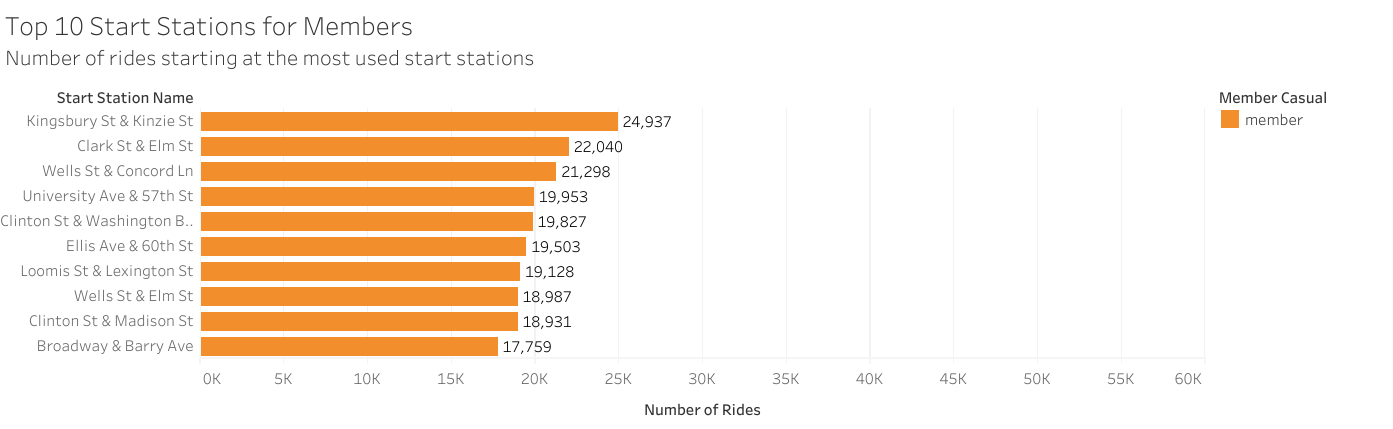

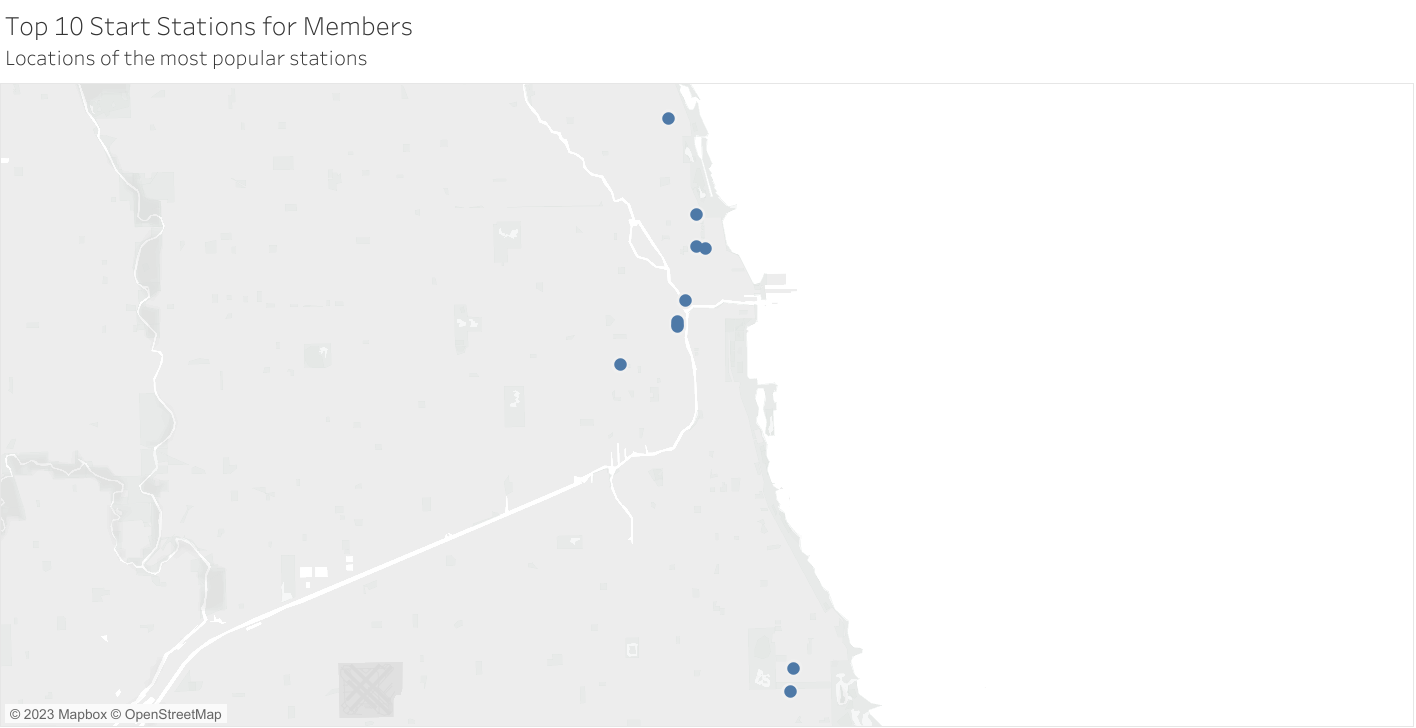

In [36]:
# member data frame
mem_df = df_raw[df_raw['member_casual'] == 'member']
# casual data frame
cas_df = df_raw[df_raw['member_casual'] == 'casual']

In [38]:
# top 10 start stations for members
mem_df['start_station_name'].value_counts().head(10)

Kingsbury St & Kinzie St        24936
Clark St & Elm St               22037
Wells St & Concord Ln           21298
University Ave & 57th St        19949
Clinton St & Washington Blvd    19827
Ellis Ave & 60th St             19501
Loomis St & Lexington St        19128
Wells St & Elm St               18986
Clinton St & Madison St         18931
Broadway & Barry Ave            17757
Name: start_station_name, dtype: int64

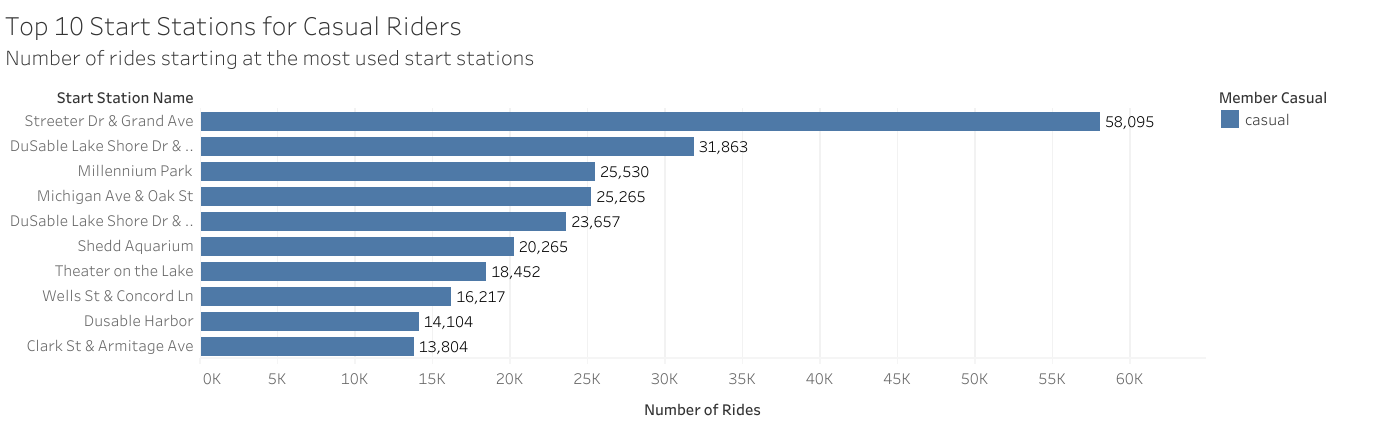

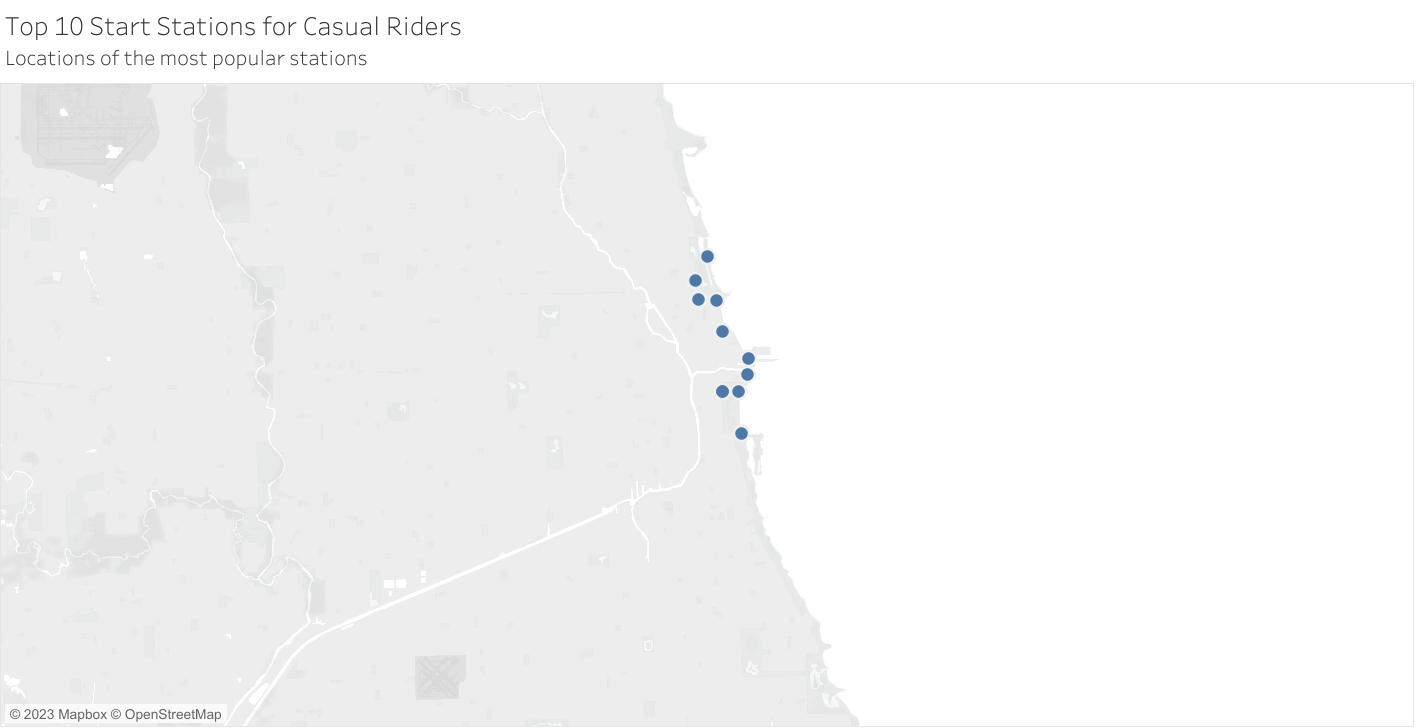

In [39]:
# top 10 start stations for casual riders
cas_df['start_station_name'].value_counts().head(10)

Streeter Dr & Grand Ave               58083
DuSable Lake Shore Dr & Monroe St     31860
Millennium Park                       25524
Michigan Ave & Oak St                 25264
DuSable Lake Shore Dr & North Blvd    23655
Shedd Aquarium                        20265
Theater on the Lake                   18450
Wells St & Concord Ln                 16215
Dusable Harbor                        14101
Clark St & Armitage Ave               13802
Name: start_station_name, dtype: int64